In [1]:
# Load .data/mot/test_results.csv as a dataframe

import pandas as pd
import os

mot = pd.read_csv('.data/mot/test_result.csv', sep='|')

# drop the test_id and vehicle_id columns
mot = mot.drop(['test_id'], axis=1)
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,838565361,2023-01-02,4,NT,P,179357.0,NW,TOYOTA,PRIUS +,WHITE,HY,1798.0,2016-06-17
1,484499974,2023-01-01,4,NT,P,300072.0,B,TOYOTA,PRIUS,RED,HY,1500.0,2008-09-13
2,53988366,2023-01-02,4,NT,PRS,307888.0,HA,TOYOTA,PRIUS,GREY,HY,1497.0,2010-01-15
3,606755010,2023-01-02,4,NT,F,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28
4,606755010,2023-01-02,4,RT,P,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216716,1401380910,2023-12-31,4,NT,P,85583.0,EN,HONDA,BEAT,SILVER,PE,660.0,1999-10-01
42216717,625178603,2023-12-31,7,NT,P,227563.0,SK,RENAULT,MASTER,WHITE,DI,2298.0,2016-09-01
42216718,820545620,2023-12-31,4,NT,P,120115.0,S,PEUGEOT,207,SILVER,DI,1560.0,2010-01-21
42216719,941704896,2023-12-31,4,NT,P,141891.0,S,NISSAN,MICRA,RED,PE,1240.0,2009-06-25


## Pre-processing

In [2]:
# Drop any first_use and test_date before 1970, to avoid invalid ages due to the UNIX epoch
mot = mot[mot['first_use_date'] >= '1970-01-01']
mot = mot[mot['test_date'] >= '1970-01-01']

# Calculate an age column (in days) based on the test_date and first_use_date columns
mot['test_date'] = pd.to_datetime(mot['test_date'])
mot['first_use_date'] = pd.to_datetime(mot['first_use_date'])
mot['age'] = (mot['test_date'] - mot['first_use_date']).dt.days
mot['age_years'] = mot['age'] / 365.25

# Combine make and model into one column
mot['make_model'] = mot['make'] + ' ' + mot['model']  # Combine make and model into one column

# Let us focus on data where cylinder capacity is between 500 and 5000
mot = mot[(mot['cylinder_capacity'] >= 500) & (mot['cylinder_capacity'] <= 5000)]

# Drop any negative ages, as they are likely to be errors
mot = mot[mot['age'] >= 0]
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,age,age_years,make_model
0,838565361,2023-01-02,4,NT,P,179357.0,NW,TOYOTA,PRIUS +,WHITE,HY,1798.0,2016-06-17,2390,6.543463,TOYOTA PRIUS +
1,484499974,2023-01-01,4,NT,P,300072.0,B,TOYOTA,PRIUS,RED,HY,1500.0,2008-09-13,5223,14.299795,TOYOTA PRIUS
2,53988366,2023-01-02,4,NT,PRS,307888.0,HA,TOYOTA,PRIUS,GREY,HY,1497.0,2010-01-15,4735,12.963723,TOYOTA PRIUS
3,606755010,2023-01-02,4,NT,F,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28,5759,15.767283,TOYOTA PRIUS
4,606755010,2023-01-02,4,RT,P,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28,5759,15.767283,TOYOTA PRIUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216716,1401380910,2023-12-31,4,NT,P,85583.0,EN,HONDA,BEAT,SILVER,PE,660.0,1999-10-01,8857,24.249144,HONDA BEAT
42216717,625178603,2023-12-31,7,NT,P,227563.0,SK,RENAULT,MASTER,WHITE,DI,2298.0,2016-09-01,2677,7.329227,RENAULT MASTER
42216718,820545620,2023-12-31,4,NT,P,120115.0,S,PEUGEOT,207,SILVER,DI,1560.0,2010-01-21,5092,13.941136,PEUGEOT 207
42216719,941704896,2023-12-31,4,NT,P,141891.0,S,NISSAN,MICRA,RED,PE,1240.0,2009-06-25,5302,14.516085,NISSAN MICRA


In [3]:
# Sample the data for only the top 20 make and model combinations
top_20 = mot['make_model'].value_counts().head(20).index
mot = mot[mot['make_model'].isin(top_20)]
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,age,age_years,make_model
21,1493398641,2023-01-01,4,NT,P,41682.0,SR,NISSAN,JUKE,GREY,DI,1461.0,2016-05-13,2424,6.636550,NISSAN JUKE
25,1200062230,2023-01-01,4,NT,P,91473.0,G,VOLKSWAGEN,GOLF,SILVER,DI,1598.0,2010-03-20,4670,12.785763,VOLKSWAGEN GOLF
26,1237843361,2023-01-01,4,NT,PRS,162891.0,B,VOLKSWAGEN,TRANSPORTER,WHITE,DI,1968.0,2012-10-01,3744,10.250513,VOLKSWAGEN TRANSPORTER
30,922055125,2023-01-01,4,NT,P,21153.0,CO,FORD,FOCUS,BLACK,PE,999.0,2020-01-31,1066,2.918549,FORD FOCUS
37,534002476,2023-01-01,4,NT,PRS,103365.0,B,HONDA,JAZZ,BLUE,PE,1339.0,2004-03-04,6877,18.828200,HONDA JAZZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216701,700228101,2023-12-31,4,NT,PRS,105679.0,LU,NISSAN,JUKE,WHITE,PE,1598.0,2014-03-24,3569,9.771389,NISSAN JUKE
42216705,677896545,2023-12-31,4,NT,P,169683.0,SA,AUDI,A3,RED,PE,1395.0,2014-12-16,3302,9.040383,AUDI A3
42216709,541766398,2023-12-31,4,NT,P,79328.0,SP,VAUXHALL,ASTRA,BLACK,PE,1796.0,2008-03-06,5778,15.819302,VAUXHALL ASTRA
42216710,144320145,2023-12-31,4,NT,P,53210.0,G,VAUXHALL,CORSA,RED,PE,1398.0,2019-05-31,1675,4.585900,VAUXHALL CORSA


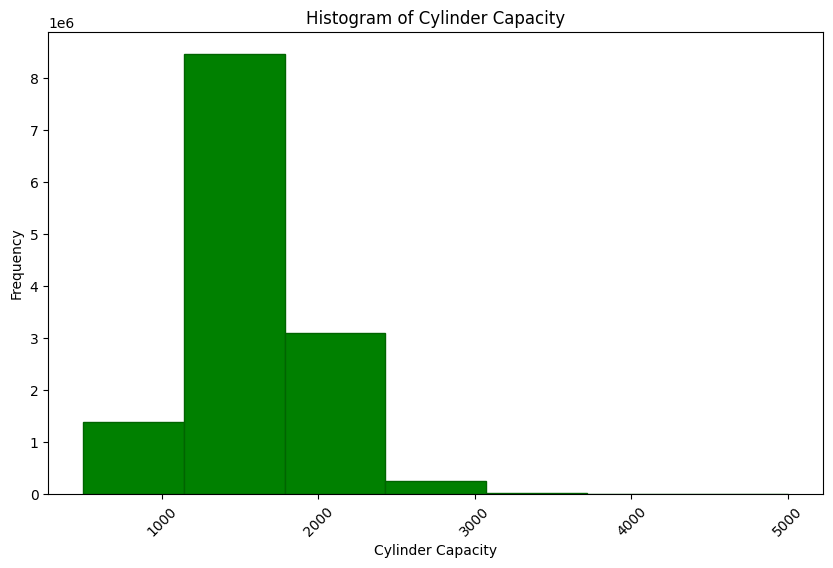

In [4]:
import matplotlib.pyplot as plt

# Plot an histogram of cylinder_capacity
plt.figure(figsize=(10, 6))
mot['cylinder_capacity'].plot(kind='hist', bins=7, color='green', edgecolor='darkgreen')
plt.title('Histogram of Cylinder Capacity')
plt.xlabel('Cylinder Capacity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

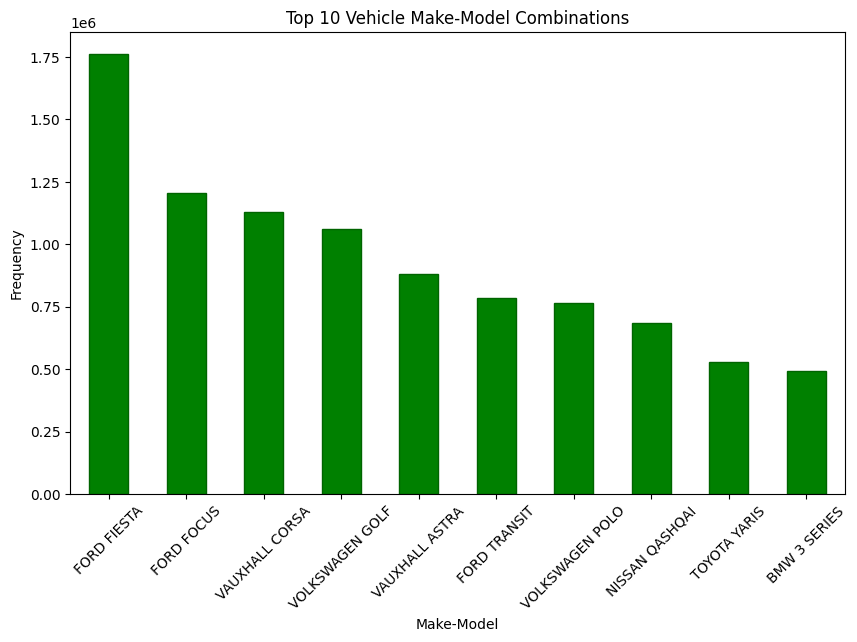

In [5]:
# Calculate the top 10 most common make-model combinations
top_vehicles = mot['make_model'].value_counts().head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_vehicles.plot(kind='bar', color='green', edgecolor='darkgreen')
plt.title('Top 10 Vehicle Make-Model Combinations')
plt.xlabel('Make-Model')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

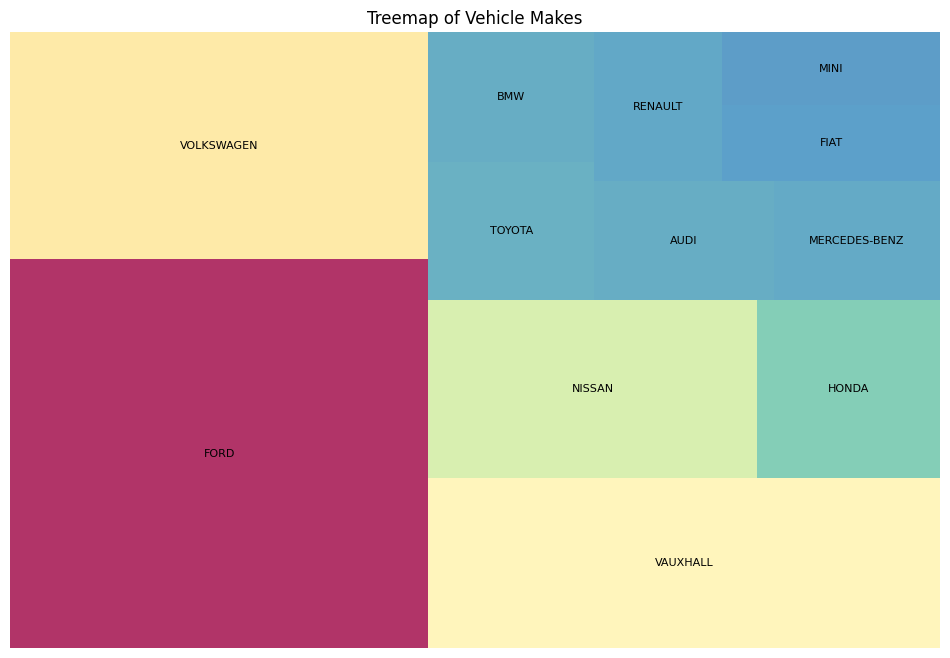

In [6]:
import squarify

counts = mot['make'].value_counts().head(30)

labels = counts.index
sizes = counts.values
colors = plt.cm.Spectral_r(sizes / max(sizes))  # Color coding by size

# Creating the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 8})
plt.title('Treemap of Vehicle Makes')
plt.axis('off')  # Remove axes
plt.show()

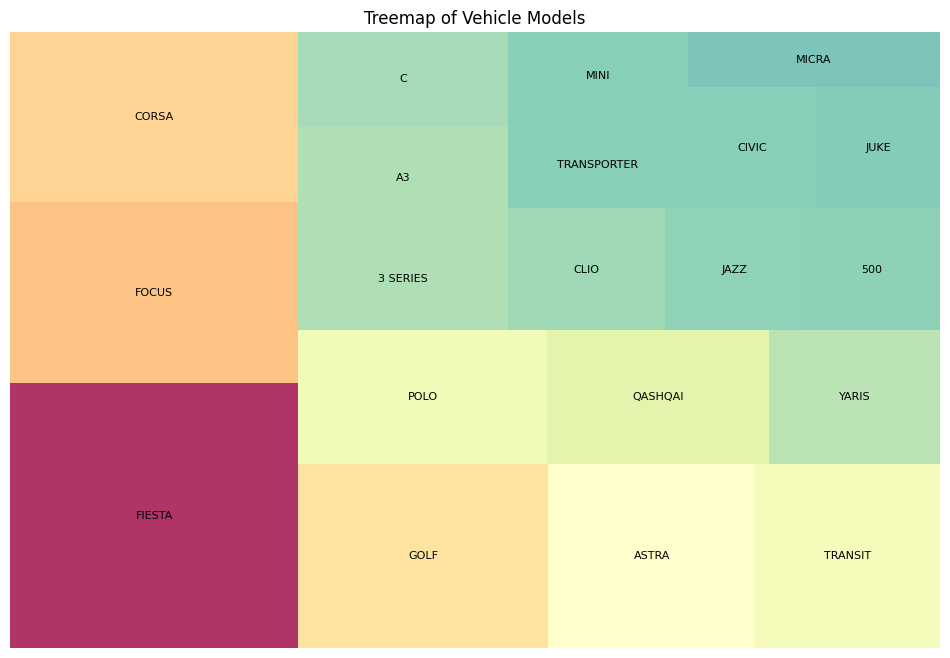

In [7]:
# Calculate the top 30 most common models
counts = mot['model'].value_counts().head(30)

labels = counts.index
sizes = counts.values
colors = plt.cm.Spectral_r(sizes / max(sizes))  # Color coding by size

# Creating the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 8})
plt.title('Treemap of Vehicle Models')
plt.axis('off')  # Remove axes
plt.show()

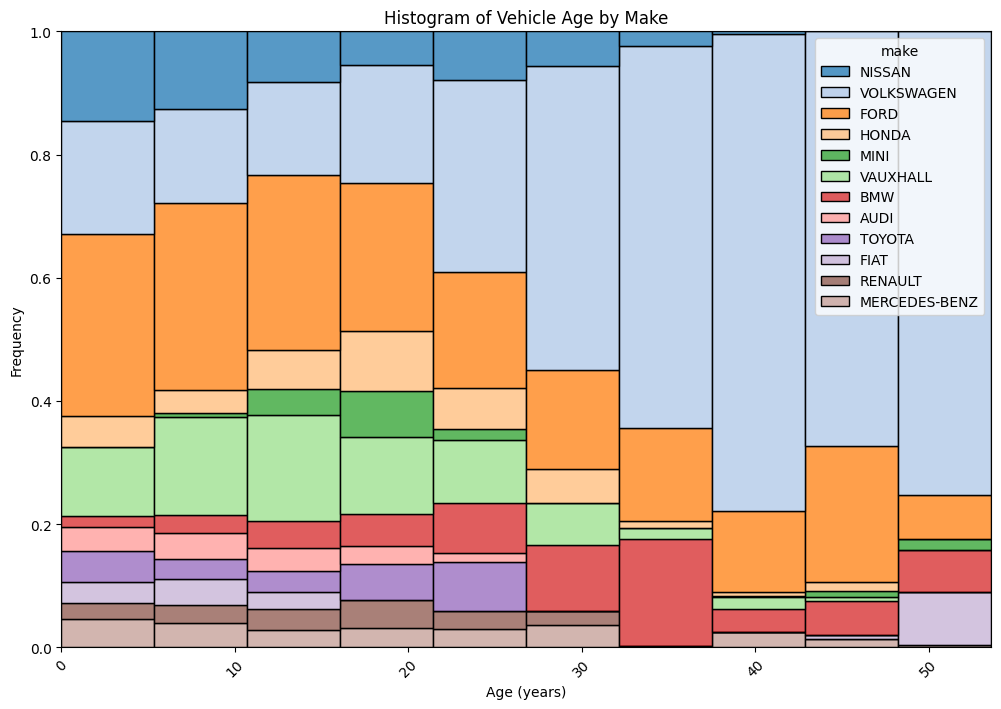

In [8]:
import seaborn as sns

# Plot a normalized matrix of histograms per make of the age of vehicles in years
plt.figure(figsize=(12, 8))
sns.histplot(data=mot, x='age_years', hue='make', bins=10, multiple='fill', palette='tab20')
plt.title('Histogram of Vehicle Age by Make')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


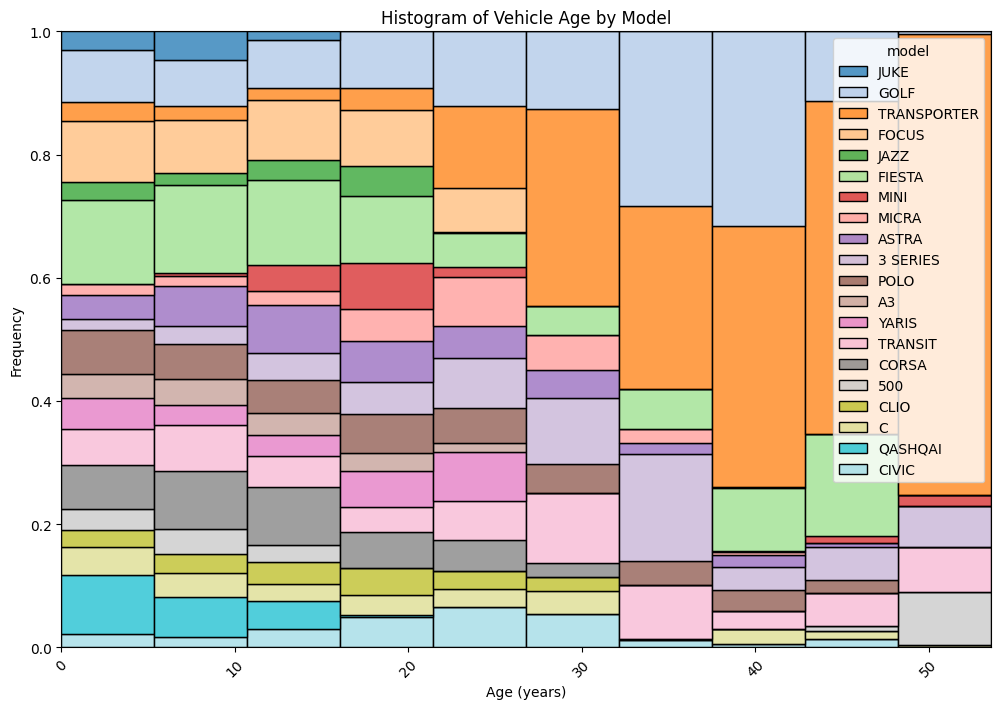

In [9]:

# Plot a normalized matrix of histograms per model of the age of vehicles in years
plt.figure(figsize=(12, 8))
sns.histplot(data=mot, x='age_years', hue='model', bins=10, multiple='fill', palette='tab20')
plt.title('Histogram of Vehicle Age by Model')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

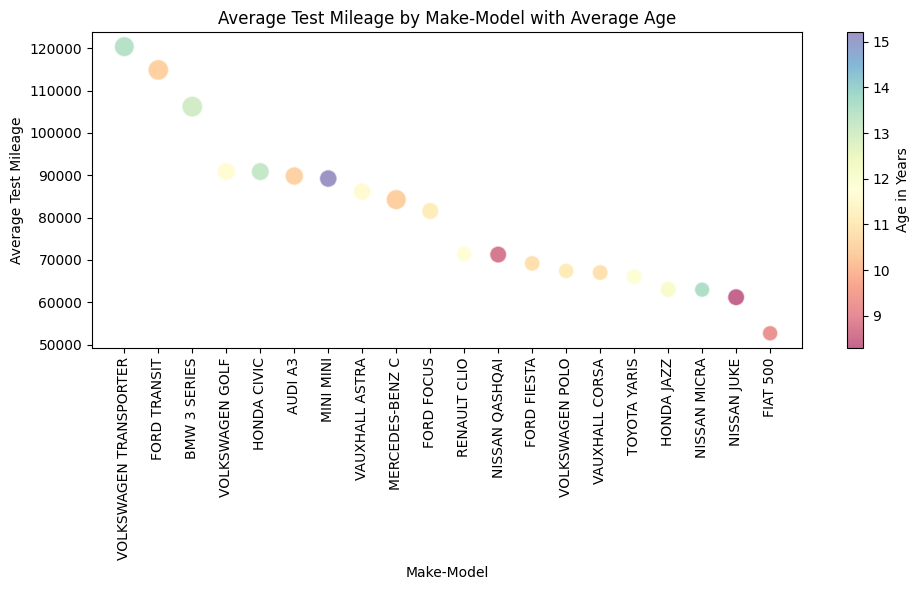

In [10]:
# Calculate the average test mileage
avg_mileage = mot.groupby(['make_model', 'make'])['test_mileage'].mean().reset_index()

# Calculate the average age in years for each make_model as a proxy for size
avg_age_years = mot.groupby(['make_model', 'make'])['age_years'].mean().reset_index()

# Calculate the average cylinder capacity for each make_model
avg_capacity = mot.groupby(['make_model', 'make'])['cylinder_capacity'].mean().reset_index()

# Merge the average mileage data with the average age years
merged_data = avg_mileage.merge(avg_age_years, on=['make_model', 'make'])

# Merge the merged data with the average capacity
merged_data = merged_data.merge(avg_capacity, on=['make_model', 'make'])

# Sort the data by average mileage
top_avg_mileage = merged_data.sort_values(by='test_mileage', ascending=False)

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size
scatter = plt.scatter(
    'make_model',  # x-axis
    'test_mileage',  # y-axis
    c=top_avg_mileage['age_years'],
    s = top_avg_mileage['cylinder_capacity']/10,  # Bubble size based on average cilinder capacity
    cmap='Spectral',  # Color map
    data=top_avg_mileage,  # Data source
    alpha=0.6,  # Transparency of the bubbles
    edgecolors='w',  # Bubble edge color
    linewidth=1  # Width of the edge
)

# Add titles and labels
plt.title('Average Test Mileage by Make-Model with Average Age')
plt.xlabel('Make-Model')
plt.ylabel('Average Test Mileage')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Create colorbar
plt.colorbar(scatter, label='Age in Years')

# Show the plot
plt.tight_layout()
plt.show()


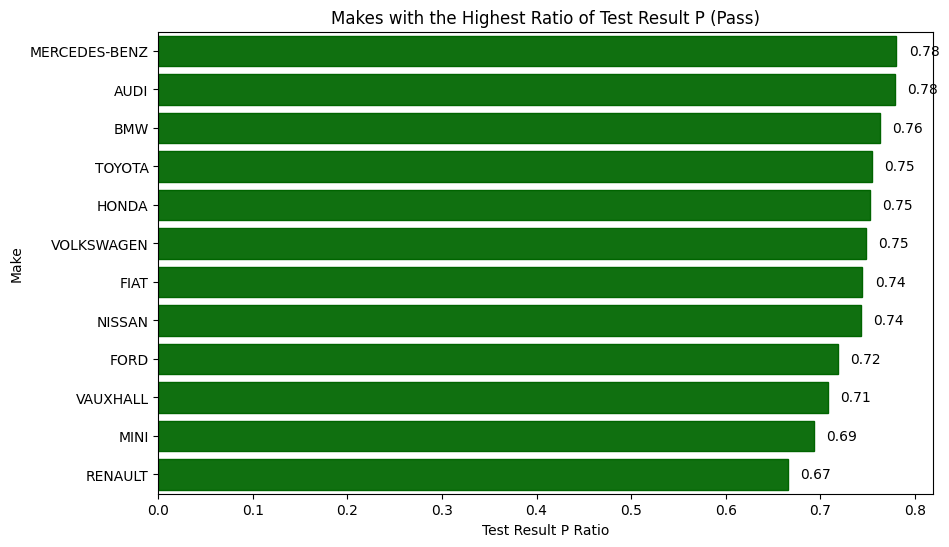

In [11]:

# Find the makes with the highest ratio of test_result = P
make_counts = mot['make'].value_counts()
make_p_counts = mot[mot['test_result'] == 'P']['make'].value_counts()
make_p_ratio = make_p_counts / make_counts
make_p_ratio = make_p_ratio.sort_values(ascending=False)

# Convert the Series to DataFrame for plotting
make_p_ratio_df = make_p_ratio.reset_index()
make_p_ratio_df.columns = ['Make', 'Test Result P Ratio']

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    y='Make',  # Now 'Make' is on the y-axis
    x='Test Result P Ratio',  # And 'Test Result P Ratio' on the x-axis
    data=make_p_ratio_df,
    color='green',
    edgecolor='darkgreen'
)

# Adding a title and labels
plt.title('Makes with the Highest Ratio of Test Result P (Pass)')
plt.ylabel('Make')  # Now this is the y-axis label
plt.xlabel('Test Result P Ratio')  # And this is the x-axis label

# This rotates the y-axis labels, which can be omitted if not necessary
plt.yticks(rotation=0)  # You can adjust the rotation for readability if needed

# Add value labels next to the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),  # Change to get_width() because width is the measure now
                     (p.get_width(), p.get_y() + p.get_height() / 2.),  # Adjust position to be at the end of the bar
                     ha='left', va='center',  # Align text to the left of the endpoint
                     xytext=(9, 0),  # Move text to the right a bit
                     textcoords='offset points')

barplot.set_facecolor('white')

# Show the plot
plt.show()



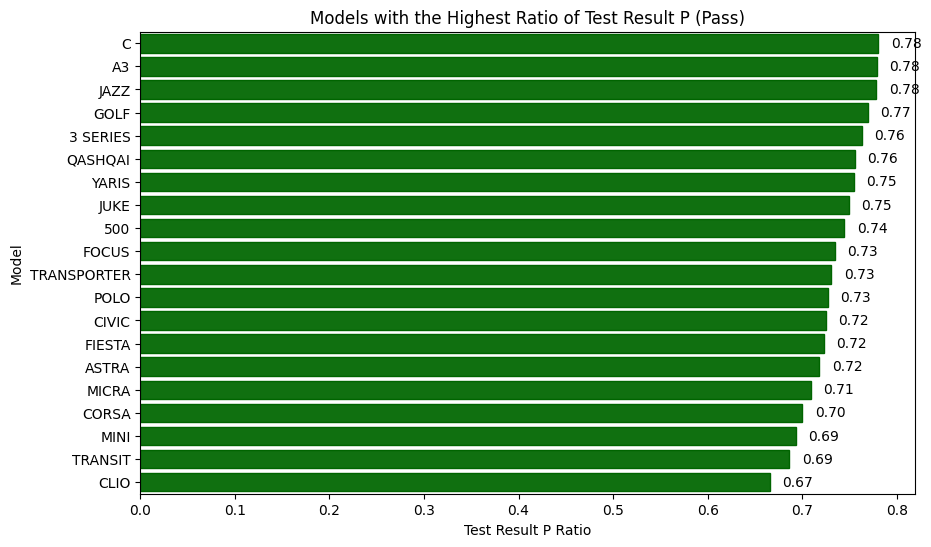

In [12]:

# Find the models with the highest ratio of test_result = P
model_counts = mot['model'].value_counts()
model_p_counts = mot[mot['test_result'] == 'P']['model'].value_counts()
model_p_ratio = model_p_counts / model_counts
model_p_ratio = model_p_ratio.sort_values(ascending=False)

# Convert the Series to DataFrame for plotting
model_p_ratio_df = model_p_ratio.reset_index()
model_p_ratio_df.columns = ['Model', 'Test Result P Ratio']

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    y='Model',  # 'Model' is now on the y-axis
    x='Test Result P Ratio',  # 'Test Result P Ratio' is on the x-axis
    data=model_p_ratio_df,
    color='green',
    edgecolor='darkgreen'
)

# Adding a title and labels
plt.title('Models with the Highest Ratio of Test Result P (Pass)')
plt.ylabel('Model')  # y-axis label is now 'Model'
plt.xlabel('Test Result P Ratio')  # x-axis label is 'Test Result P Ratio'

# No need to rotate y-axis labels in a horizontal plot
plt.yticks(rotation=0)

# Add value labels next to the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),  # Using get_width() for horizontal bars
                     (p.get_width(), p.get_y() + p.get_height() / 2.),  # Position at the end of the bar
                     ha='left', va='center',  # Align text to the left of the endpoint
                     xytext=(9, 0),  # Move text to the right a bit
                     textcoords='offset points')

barplot.set_facecolor('white')

# Show the plot
plt.show()

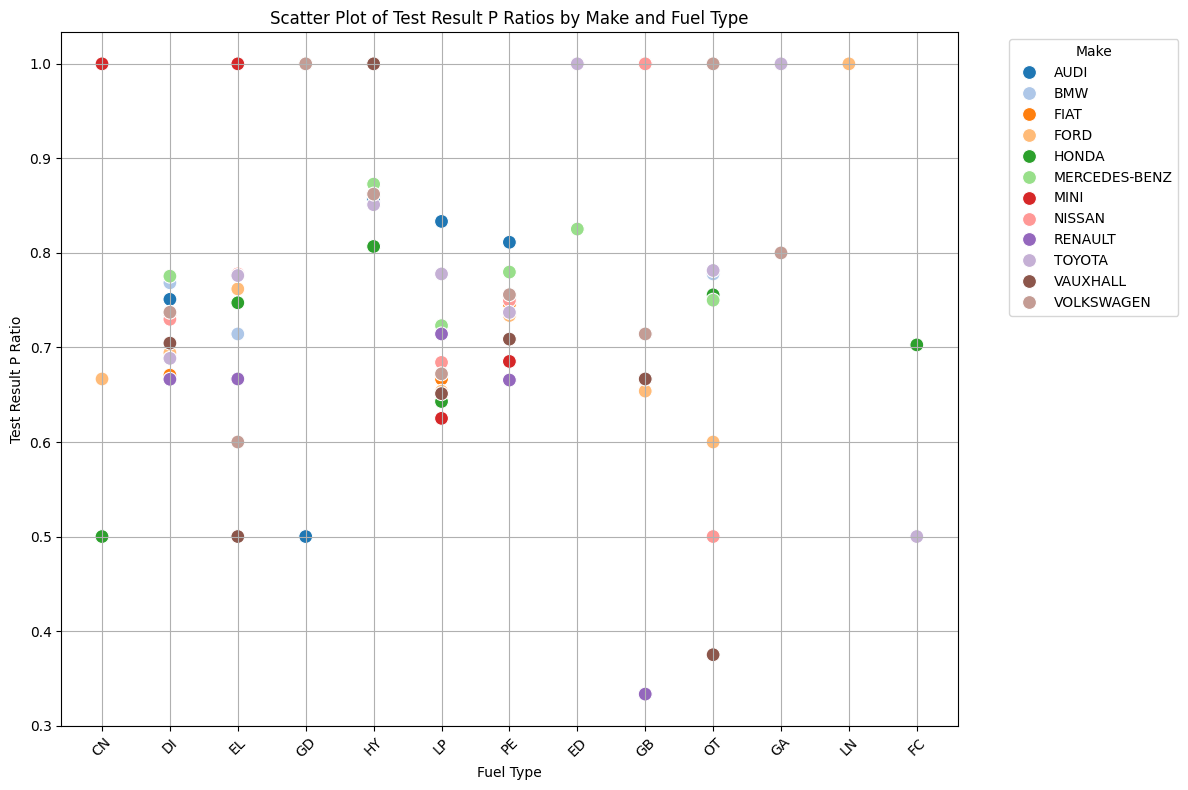

In [13]:

# Calculate counts and ratios as before, change to grouping by 'make'
make_fuel_counts = mot.groupby(['make', 'fuel_type']).size()
make_p_fuel_counts = mot[mot['test_result'] == 'P'].groupby(['make', 'fuel_type']).size()
make_p_ratio = make_p_fuel_counts / make_fuel_counts

# Resetting the index to turn the multi-index Series into a DataFrame
make_p_ratio_df = make_p_ratio.reset_index()
make_p_ratio_df.columns = ['Make', 'Fuel Type', 'Test Result P Ratio']

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x='Fuel Type',
    y='Test Result P Ratio',
    hue='Make',  # Differentiate by make
    data=make_p_ratio_df,
    palette='tab20',  # Color palette
    s=100  # Size of the markers
)

plt.title('Scatter Plot of Test Result P Ratios by Make and Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Test Result P Ratio')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for easier visual alignment

# Moving the legend outside the plot area to the right
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()




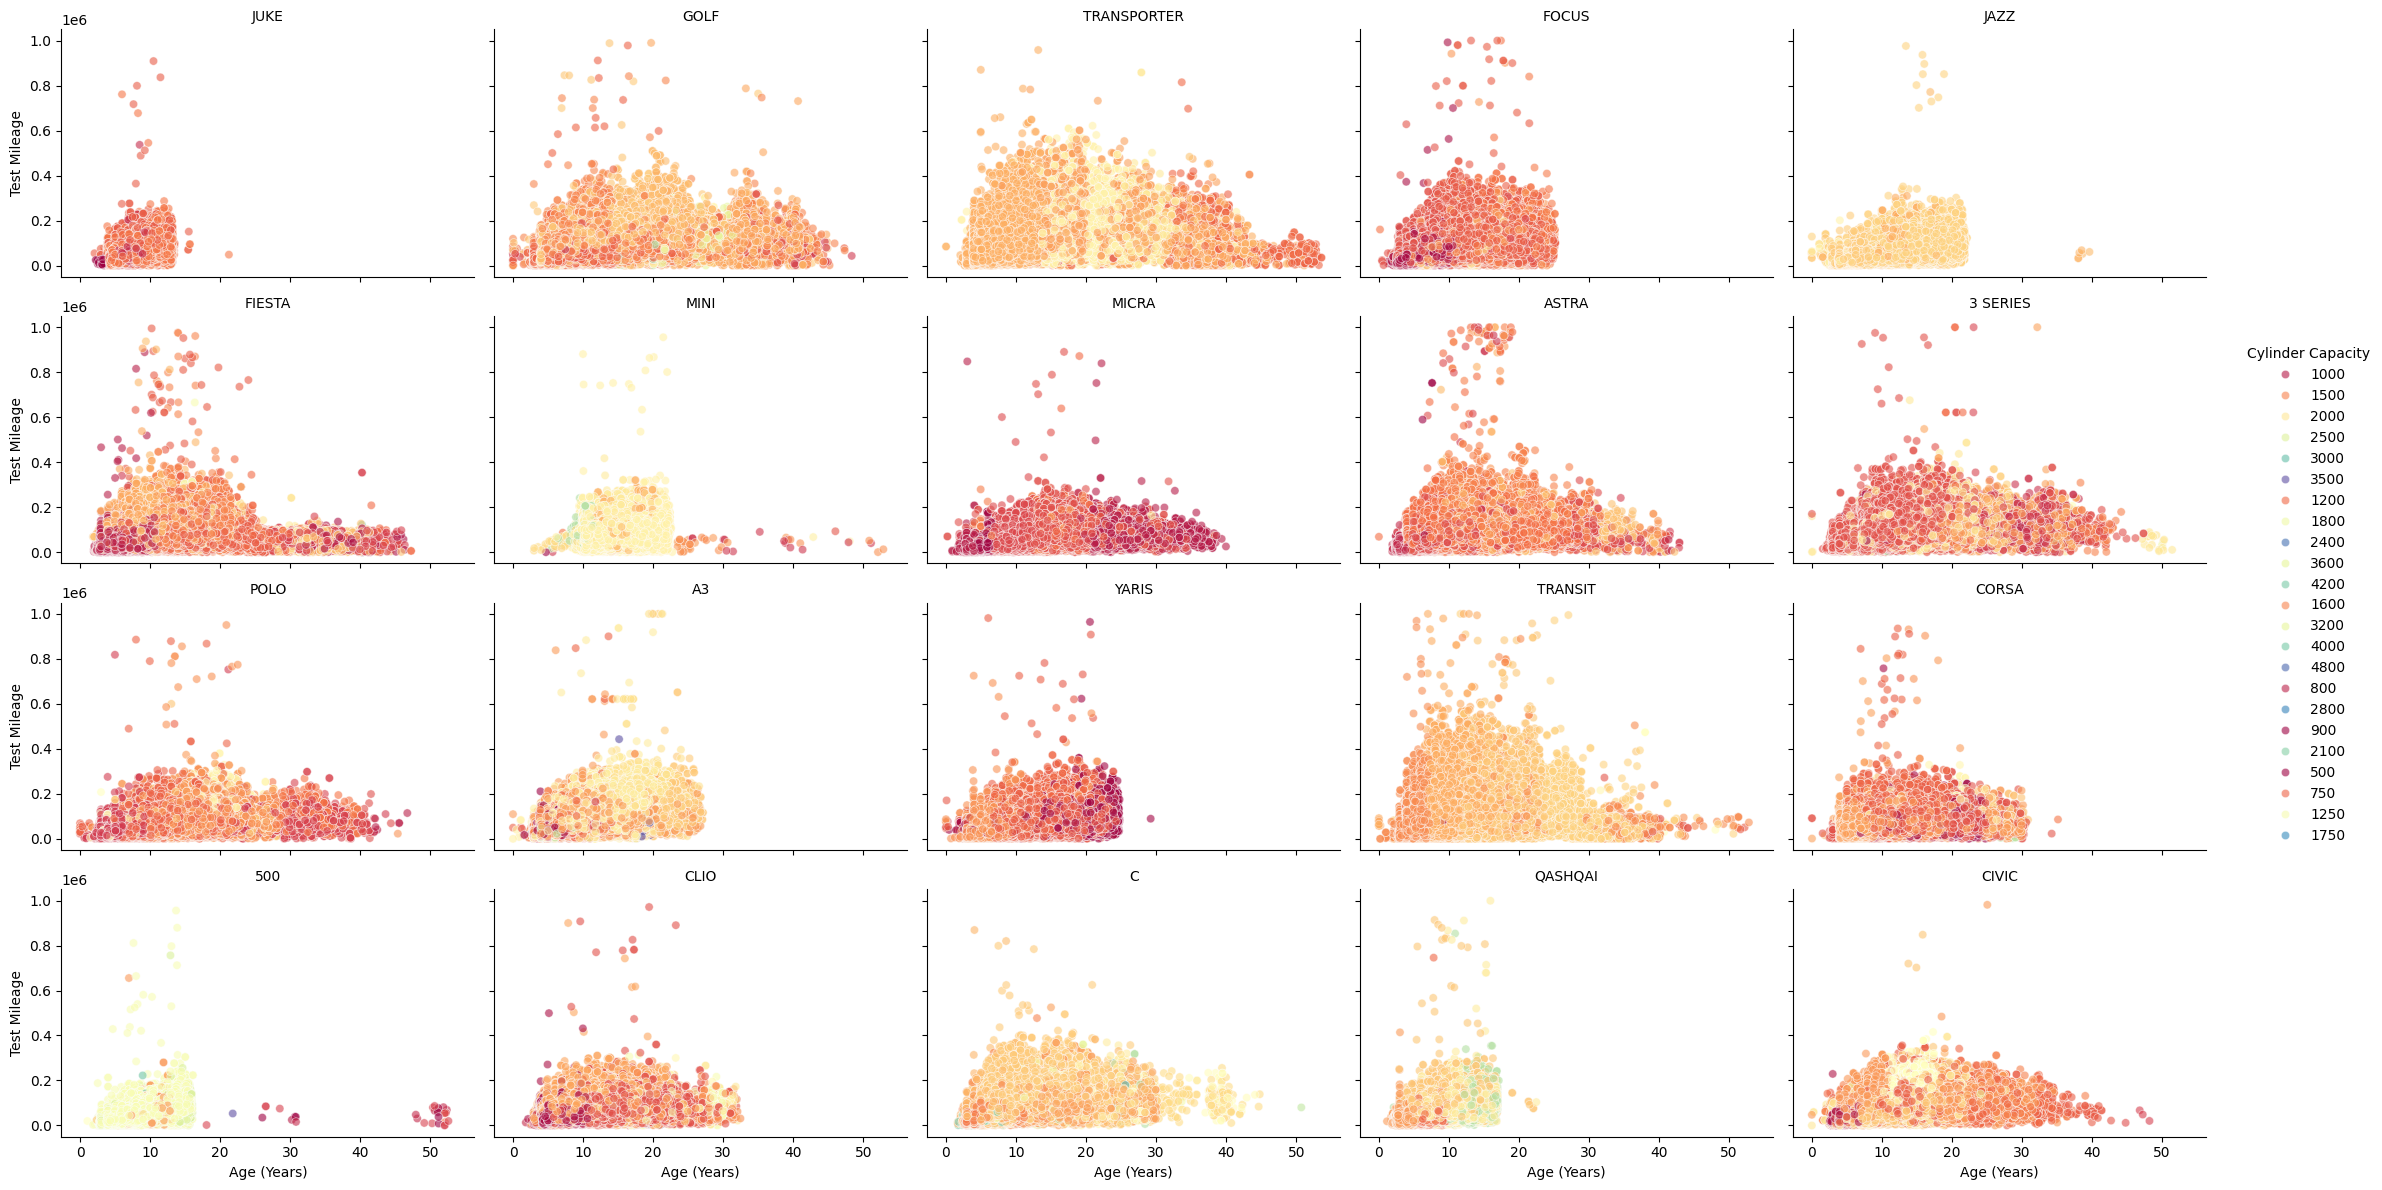

In [14]:
# Initialize a FacetGrid object
g = sns.FacetGrid(mot, col='model', col_wrap=5, aspect=1.5)

# Map the scatterplot with the Spectral colormap for the 'cylinder_capacity' which affects the color
g.map_dataframe(sns.scatterplot, 'age_years', 'test_mileage', 
                 alpha=0.6, palette='Spectral', hue='cylinder_capacity')

# Add titles and tweak adjustments
g.set_titles("{col_name}")  # Use model names as titles for each subplot
g.set_axis_labels("Age (Years)", "Test Mileage")  # Set common axis labels

# Add a legend and adjust layout
g.add_legend(title='Cylinder Capacity')
g.tight_layout()

# Display the plots
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Create a copy of the DataFrame for manipulation which includes a portion of the data
mot_encoded = mot.sample(frac=0.5, random_state=42)

# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['make', 'model', 'fuel_type']  # Categorical columns to encode
for col in categorical_columns:
    mot_encoded[col] = le.fit_transform(mot_encoded[col])

# Features and Target
X = mot_encoded[['test_mileage', 'cylinder_capacity', 'age_years', 'make', 'model', 'fuel_type']]  # Feature selection
y = mot_encoded['test_result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
n_jobs = -1 # Use all available cores
n_estimators = 100 # Number of trees
rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=n_jobs)
rf.fit(X_train, y_train)

# Predict on the test data
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances


Accuracy: 0.6365227255539591
              precision    recall  f1-score   support

         ABA       0.09      0.07      0.08       937
         ABR       0.67      0.64      0.65      7048
       ABRVE       0.00      0.00      0.00         1
           F       0.13      0.08      0.10    277739
           P       0.72      0.84      0.78    967169
         PRS       0.08      0.01      0.02     69406

    accuracy                           0.64   1322300
   macro avg       0.28      0.27      0.27   1322300
weighted avg       0.56      0.64      0.59   1322300



,feature,importance
0,test_mileage,0.555343
1,age_years,0.423456
2,cylinder_capacity,0.012322
3,model,0.004519
4,make,0.003003
5,fuel_type,0.001357


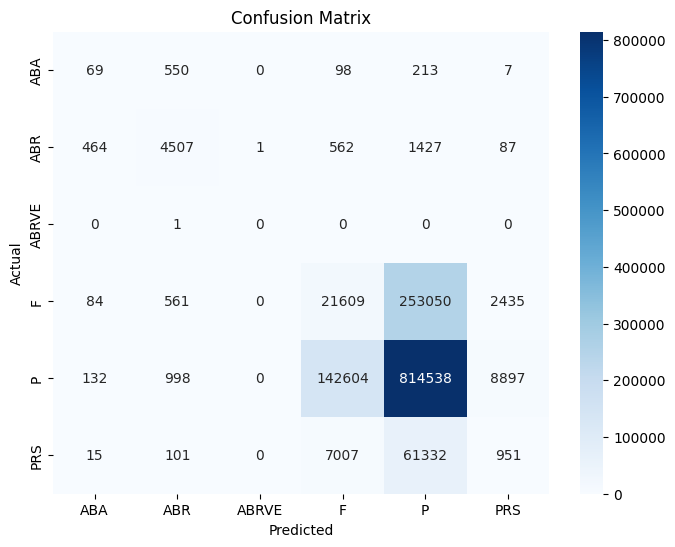

In [16]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()